In [7]:
# NEW IRON (12566.768) NEW H (12818.07)

In [8]:
import scipy.optimize as optimize
from scipy.interpolate import griddata
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import operator
import glob
import os
%matplotlib inline

In [9]:
rawobsflux = pd.read_excel("nallen/Dered_Fluxes.xlsx")  # observational data read in
obsflux = rawobsflux[-18:]
rawunc = pd.read_excel("nallen/Dered_Uncertanties.xlsx")
obsunc = rawunc[-18:]

obsflux = obsflux.values  # usable values: flux and uncertainty
obsunc = obsunc.values

In [10]:
obsSi = obsflux[:1]  # separating data by spectral line
obsFe26 = obsflux[1:2]
obsS = obsflux[2:3]
obsFe179 = obsflux[3:4]
obsNe = obsflux[4:5]
obsFe16 = obsflux[13:14]

In [11]:
runcSi = obsunc[:1]  # raw, same for uncertainties
runcFe26 = obsunc[1:2]
runcS = obsunc[2:3]
runcFe179 = obsunc[3:4]
runcNe = obsunc[4:5]
runcFe16 = obsunc[13:14]

In [12]:
def nonzero(full,obs):  # setting zero uncertainty values (1/3 upper limit)
    new = []
    for i in range(len(full[0])):
        if full[0][i] == 0:
            use = obs[0][i]/3.
            new.append(use)
            continue
        else:
            new.append(full[0][i])
            continue
    return(new)
            

In [13]:
uncSi = nonzero(runcSi, obsSi)  # final uncertainties by line
uncFe26 = nonzero(runcFe26, obsFe26)
uncS = nonzero(runcS, obsS)
uncFe179 = nonzero(runcFe179, obsFe179)
uncNe = nonzero(runcNe, obsNe)
uncFe16 = nonzero(runcFe16, obsFe16)

In [14]:
length = ["1",'2','3','4','5','6','7','8']  #bad old method

#lenmid = 3311  # importing shock simulation grids
#newmid = []
#for i in range(1,lenmid+1):
#    name = "S5_Shocks/NewMid/ShockFiles/ShockSpectrum" + str(i) + ".csv"
#    data = pd.read_csv(name, names = length, engine = 'python')
#    newmid.append(data)


In [15]:
#lenmid2 = 3311
#newmid2 = []
#for i in range(1,lenmid2+1):
#    name2 = "S5_Shocks/NewMid2/ShockFiles/ShockSpectrum" + str(i) + ".csv"
#    data2 = pd.read_csv(name2, names = length, engine = 'python')
#    newmid2.append(data2)

In [16]:
# implementing natural sorting (ref: https://stackoverflow.com/questions/5967500/how-to-correctly-sort-a-string-with-a-number-inside)

import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [17]:
def fileread(path): #read in the path to the shock files directory, form "S5_Shocks/NewMid/ShockFiles/ShockSpectrum*.csv"
    directory = glob.glob(path)
    directory.sort(key=natural_keys) #key=os.path.getmtime
    files = []
    length = ['1','2','3','4','5','6','7','8']
    for i in directory:
        data = pd.read_csv(i, names = length, engine = 'python')
        files.append(data)
    
    return files


In [18]:
def initial(file):  # taking the important information out of the file (wavelengths and fluxes)
    rawdata = file[-len(file)+88:]
    rawwl = rawdata["1"]
    wl = []
    for j in rawwl:
        num = float(j)
        u = num/10000  # converting to microns
        wl.append(u)
    raweps = rawdata["3"]
    eps = []
    for k in raweps:
        nums = float(k)
        eps.append(nums)
    uses = []
    for a in range(len(eps)):
        vals = [eps[a],wl[a]]
        uses.append(vals)
    return uses

In [19]:
def pointlistmake(filelist):  # making a point of (velocity,density) that maps to each wavelength intensity
    pointlist = []
    
    for file in filelist:
        fslice = file.values[5][0]
        unlist = []
        for i in (i for i,x in enumerate(fslice) if x == '_'): # finding the file points containing the velocity
            unlist.append(i)
        fvel = unlist[0] + 1

        for i in (i for i,x in enumerate(fslice) if x == 'k'):
            lvel = i
        
        vel = fslice[fvel:lvel] 

        fden = unlist[1] + 1

        for i in (i for i,x in enumerate(fslice) if x == 'g'):  # same for density
            lden = i

        den = fslice[fden:lden]

        point = [vel, den]
        pointlist.append(point)
    
    return(pointlist)

In [20]:
def modlistmake(file):
    modlist = []
    t = 0
    while t < len(file):
        lst = file[t]
        listup = initial(lst)
        
        muep = [item[0] for item in listup]
        muwl = [item[1] for item in listup]
        
        for i in (i for i,x in enumerate(muwl) if x == 34.8140927):  # 34.8 Si line
            usi = muep[i]
        
        for i in (i for i,x in enumerate(muwl) if x == 25.988404):  # 26 Fe line
            ufe1 = muep[i]
            
        for i in (i for i,x in enumerate(muwl) if x == 25.2490184):  # Sulfur line 1
            us1 = muep[i]
        
        for i in (i for i,x in enumerate(muwl) if x == 25.2):  # Sulfur line 2
            us2 = muep[i]
            
        us = us1 + us2
        
        for i in (i for i,x in enumerate(muwl) if x == 17.9360294):  # 17.9 Fe line
            ufe2 = muep[i] * (2/3)
        
        for i in (i for i,x in enumerate(muwl) if x == 12.8135475):  # Neon line
            une = muep[i]
            
        for i in (i for i,x in enumerate(muwl) if x == 1.6435526999999999):  # 1.644 Fe line
            ufe3 = muep[i]
        
        modlist.append([usi, ufe1, us, ufe2, une, ufe3])
        t = t+1
    
    return(modlist)

In [21]:
def plotmodlistmake(file):  # finding the important lines for plotting
    modlist = []
    listup = initial(file)
        
    muep = [item[0] for item in listup]
    muwl = [item[1] for item in listup]
    
    for i in (i for i,x in enumerate(muwl) if x == 34.8140927):  # 34.8 Si line
        usi = muep[i]
        
    for i in (i for i,x in enumerate(muwl) if x == 25.988404):  # 26 Fe line
        ufe1 = muep[i]
            
    for i in (i for i,x in enumerate(muwl) if x == 25.2490184):  # Sulfur line 1
        us1 = muep[i]
        
    for i in (i for i,x in enumerate(muwl) if x == 25.2):  # Sulfur line 2  
        us2 = muep[i]
            
    us = us1 + us2  # for some reason it splits this sulfur line into two so we have to add
        
    for i in (i for i,x in enumerate(muwl) if x == 17.9360294):  # 17.9 Fe line
        ufe2 = muep[i] * (2/3)
        
    for i in (i for i,x in enumerate(muwl) if x == 12.8135475):  # Neon line
        une = muep[i]
            
    for i in (i for i,x in enumerate(muwl) if x == 1.6435526999999999):  # 1.644 Fe line
        ufe3 = muep[i]
     
    modlist.append([usi, ufe1, us, ufe2, une, ufe3])
    
    return(modlist)

In [22]:
def initialize(path): #"Documents/GGD37/Odd_Vel/ShockSpectrum*.csv", all you should need to do is run this function
    files = fileread(path)
    #felist = femodlistmake(files)
    modlist = modlistmake(files)
    pointlist = pointlistmake(files)
    #ratiolist = fe_ratios(felist)
    
    return pointlist, modlist

In [23]:
pointnewmid, modnewmid = initialize("S5_Shocks/NewMid/ShockFiles/ShockSpectrum*.csv")

In [24]:
#modnewtop = modlistmake(newtop)  # initializing lists from files (same can be done for any modlist/pointlist)
#modnewtop2 = modlistmake(newtop2)
#modnewmid = modlistmake(newmid)
#modnewmid2 = modlistmake(newmid2)

In [25]:
#pointnewtop = pointlistmake(newtop)
#pointnewtop2 = pointlistmake(newtop2)
#pointnewmid = pointlistmake(newmid)
#pointnewmid2 = pointlistmake(newmid2)

In [26]:
def matchfind(nplist, scalelist, idx, pointlist):  # finding the scale value, parameters of matched shock
    ipos = nplist[idx]
    print pointlist
    
    scale = scalelist[idx]
    pos = pointlist[ipos]
    need = [ipos, pos, scale]
    return(need)
    

In [27]:
def chisqAll(scale, obslist, unclist, modlist):  # finding chisquare value for all lines
    slist = []
    alpha, beta, delta, epsilon, zeta = obslist[0], obslist[1], obslist[2], obslist[3], obslist[4]
    uncalpha, uncbeta, uncdelta, uncepsilon, unczeta = unclist[0], unclist[1], unclist[2], unclist[3], unclist[4]
    
    w = 0
    while w < len(modlist):  # basic chisquared minimization
        chisq = ((alpha - (modlist[w][0])*scale)/
        uncalpha)**2 + ((beta - (modlist[w][1])*scale)/
        uncbeta)**2  + ((delta - (modlist[w][3])*scale)/
        uncdelta)**2 + ((epsilon - (modlist[w][4])*scale)/
        uncepsilon)**2 + ((zeta - (modlist[w][5])*scale)/unczeta)**2
        
        slist.append(chisq)
        w = w + 1
    val = min(slist)
    for i in (i for i,x in enumerate(slist) if x == val):  
        idx = i
    ret = [val, idx]
    return(ret)


In [28]:
def allmatch(pos, modlist, pointlist): # getting all information about match, not including S
    slist = []
    nplist = []
    scalelist = []
    idxlist = []
    
    alpha = obsSi[0][pos]
    beta = obsFe26[0][pos]
    delta = obsFe179[0][pos]
    epsilon = obsNe[0][pos]
    zeta = obsFe16[0][pos]
    
    uncalpha = uncSi[pos]
    uncbeta = uncFe26[pos]
    uncdelta = uncFe179[pos]
    uncepsilon = uncNe[pos]
    unczeta = uncFe16[pos]
    
    obslist = [alpha, beta, delta, epsilon, zeta]
    unclist = [uncalpha, uncbeta, uncdelta, uncepsilon, unczeta]
    
    scale = 10**(-15)
    minim = 1000
    while scale < 10**(-10):  # setting cutoff minimum chi squared value
        nminit = chisqAll(scale, obslist, unclist, modlist)
        nmin = nminit[0]
        idxlist.append(nminit[1])
        if nmin < minim:
            minim = nmin
            slist.append(nmin)
            nplist.append(nminit[1])
        else:
            slist.append(float("inf"))
            nplist.append(float("inf"))
        
        scalelist.append(scale)
        scale = scale*1.005
    val = min(slist)
    for i in (i for i,x in enumerate(slist) if x == min(slist)):  
        idx = i
    
    values = matchfind(nplist, scalelist, idx, pointlist)
    return(val,values)
        

In [29]:
def chisqAllred(scale, obslist, unclist, modlist):  # chisquare for just 4 important lines (Si, Ne, Fe26, Fe179)
    slist = []
    alpha, beta, delta, epsilon = obslist[0], obslist[1], obslist[2], obslist[3]
    uncalpha, uncbeta, uncdelta, uncepsilon = unclist[0], unclist[1], unclist[2], unclist[3]
    
    w = 0
    while w < len(modlist):
        chisq = ((alpha - (modlist[w][0])*scale)/
        uncalpha)**2 + ((beta - (modlist[w][1])*scale)/
        uncbeta)**2 + ((delta - (modlist[w][3])*scale)/
        uncdelta)**2 + ((epsilon - (modlist[w][4])*scale)/
        uncepsilon)**2
        
        slist.append(chisq)
        w = w + 1
    val = min(slist)
    idx = np.argmin(slist)
    ret = [val, idx]
    return(ret)

In [30]:
def allmatchred(pos, modlist, pointlist):  # match for just 4 important lines 
    slist = []
    nplist = []
    scalelist = []
    idxlist = []
    
    alpha = obsSi[0][pos]  # important lines: Fe 26, 17.9, Si, Ne
    beta = obsFe26[0][pos]
    delta = obsFe179[0][pos]
    epsilon = obsNe[0][pos]
    
    uncalpha = uncSi[pos]
    uncbeta = uncFe26[pos]
    uncdelta = uncFe179[pos]
    uncepsilon = uncNe[pos]
    
    obslist = [alpha, beta, delta, epsilon]
    unclist = [uncalpha, uncbeta, uncdelta, uncepsilon]
    
    scale = 10**(-15)
    minim = 1000
    while scale < 10**(-10):
        nminit = chisqAllred(scale, obslist, unclist, modlist)
        nmin = nminit[0]
        idxlist.append(nminit[1])
        if nmin <= minim:
            minim = nmin
            slist.append(nmin)
            nplist.append(nminit[1])
        else:
            slist.append(float("inf"))
            nplist.append(float("inf"))
        
        scalelist.append(scale)
        scale = scale*1.005
    
    val = min(slist)
    idx = np.argmin(slist)
    values = matchfind(nplist, scalelist, idx, pointlist)
    return(val,values)

In [31]:
def allmatch_g(pos, modlist, pointlist): # getting all information about match
    slist = []
    nplist = []
    scalelist = []
    idxlist = []
    
    alpha = obsSi[0][pos]
    beta = obsFe26[0][pos]
    #gamma = obsS[0][pos]
    delta = obsFe179[0][pos]
    epsilon = obsNe[0][pos]
    zeta = obsFe16[0][pos]
    
    uncalpha = uncSi[pos]
    uncbeta = uncFe26[pos]
    #uncgamma = uncS[pos]
    uncdelta = uncFe179[pos]
    uncepsilon = uncNe[pos]
    unczeta = uncFe16[pos]
    
    obslist = [alpha, beta, '''gamma''', delta, epsilon, zeta]
    unclist = [uncalpha, uncbeta, '''uncgamma''', uncdelta, uncepsilon, unczeta]
    
    scale = 10**(-15)
    minim = 1000
    while scale < 10**(-10):
        nminit = chisqAll(scale, obslist, unclist, modlist)
        nmin = nminit[0]
        idxlist.append(nminit[1])
        if nmin < minim:
            minim = nmin
            slist.append(nmin)
            nplist.append(nminit[1])
        else:
            slist.append(float("inf"))
            nplist.append(float("inf"))
        
        scalelist.append(scale)
        scale = scale*1.005
    val = min(slist)
    for i in (i for i,x in enumerate(slist) if x == min(slist)):  
        idx = i
    
    values = matchfind(nplist, scalelist, idx, pointlist)
    return(val,values)
        

In [39]:
def plotspectra(file, pos, offset): # creating a wavelength vs. intensity plot for each file, with observational data
    plot = initial(file)
    ep = [item[0] for item in plot]
    wl = [item[1] for item in plot]
    
    special = plotmodlistmake(file) # [si, fe26, s, fe179, ne, fe16]
    sep = special[0]
    swl = [34.8140927, 25.988404, 25.2490184, 17.9360294, 12.8135475, 1.6435527]
    
    feplot1 = (obsFe16[0][pos])/offset
    feplot2 = (obsFe179[0][pos])/offset
    feplot3 = (obsFe26[0][pos])/offset
    siplot = (obsSi[0][pos])/offset
    neplot = (obsNe[0][pos])/offset
    splot = (obsS[0][pos])/offset
    
    ufeplot1 = (uncFe16[pos])/offset
    ufeplot2 = (uncFe179[pos])/offset
    ufeplot3 = (uncFe26[pos])/offset
    usiplot = (uncSi[pos])/offset
    uneplot = (uncNe[pos])/offset
    usplot = (uncS[pos])/offset
    
    '''
    plotfe1 = [1.6435527, feplot1]
    plotfe2 = [17.9360294, feplot2]
    plotfe3 = [25.988404, feplot3]
    plotsi = [34.8140927, siplot]
    plotne = [12.8135475, neplot]
    plots = [25.2490184, splot]
    '''
    
    obswl = [1.6435527, 17.9360294, 25.988404, 34.8140927, 12.8135475, 25.2490184]
    obsep = [feplot1, feplot2, feplot3, siplot, neplot, splot]
    interest = [siplot, feplot3, splot, feplot2, neplot, feplot1]
    #plotting = [plotfe1, plotfe2, plotfe3, plotsi, plotne, plots]
    
    fig, ax = plt.subplots(figsize = (14,8))
    
    #ax.errorbar(obswl,obsep, yerr = obsun, fmt='o', capsize=5)
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylabel('Flux (HB = 1)')
    ax.set_xlabel(r'$\rm Wavelength (\mu m)$')
    ax.annotate("Fe 1.64", xy=(1.6435527+.1, feplot1))
    ax.annotate("Fe 17.9", xy=(17.9360294-2.2, feplot2+.025))
    ax.annotate("Fe 26", xy=(25.988404-.7, feplot3+.025))
    ax.annotate("Si", xy=(34.8140927+1.5, siplot))
    ax.annotate("Ne", xy=(12.8135475-1, neplot+.015))
    ax.annotate("S", xy=(25.2490184+1.2, splot))
    ax.stem(obswl, obsep, 'b', markerfmt='bo')
    ax.stem(wl, ep, 'g', markerfmt='go')
    ax.stem(swl, sep, 'r', markerfmt='ro')
    plt.savefig("hh7large.jpg")
    plt.show()
    
    print("Observed:", interest)
    print("Simulated:", sep)
    print("Differences: Si" ,interest[0]-sep[0], ", Fe26", interest[1]-sep[1], ", S", interest[2]-sep[2],
          ", Fe179", interest[3]-sep[3], ", Ne", interest[4]-sep[4], ", Fe16", interest[5]-sep[5])
    

In [40]:
def plotspectrasmall(file, pos, offset): # creating a wavelength vs. intensity plot for each file, with observational data
    plot = initial(file)
    ep = [item[0] for item in plot]
    wl = [item[1] for item in plot]
    
    special = plotmodlistmake(file) # [si, fe26, s, fe179, ne, fe16]
    sep = special[0]
    swl = [34.8140927, 25.988404, 25.2490184, 17.9360294, 12.8135475, 1.6435527]
    
    feplot1 = (obsFe16[0][pos])/offset
    feplot2 = (obsFe179[0][pos])/offset
    feplot3 = (obsFe26[0][pos])/offset
    siplot = (obsSi[0][pos])/offset
    neplot = (obsNe[0][pos])/offset
    splot = (obsS[0][pos])/offset
    
    ufeplot1 = (uncFe16[pos])/offset
    ufeplot2 = (uncFe179[pos])/offset
    ufeplot3 = (uncFe26[pos])/offset
    usiplot = (uncSi[pos])/offset
    uneplot = (uncNe[pos])/offset
    usplot = (uncS[pos])/offset
    
    '''
    plotfe1 = [1.6435527, feplot1]
    plotfe2 = [17.9360294, feplot2]
    plotfe3 = [25.988404, feplot3]
    plotsi = [34.8140927, siplot]
    plotne = [12.8135475, neplot]
    plots = [25.2490184, splot]
    '''
    
    obswl = [1.6435527, 17.9360294, 25.988404, 34.8140927, 12.8135475, 25.2490184]
    obsep = [feplot1, feplot2, feplot3, siplot, neplot, splot]
    interest = [siplot, feplot3, splot, feplot2, neplot, feplot1]
    #plotting = [plotfe1, plotfe2, plotfe3, plotsi, plotne, plots]
    
    rwl = wl[-120:]
    rep = ep[-120:]
    
    obsun = [ufeplot1, ufeplot2, ufeplot3, usiplot, uneplot, usplot]
    
    fig, ax = plt.subplots(figsize = (14,8))
    
    ax.errorbar(obswl,obsep, yerr = obsun, fmt='o', capsize=100)
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylabel('Flux (HB = 1)')
    ax.set_xlabel(r'$\rm Wavelength (\mu m)$')
    ax.annotate("Fe 1.64", xy=(1.6435527+.1, feplot1))
    ax.annotate("Fe 17.9", xy=(17.9360294+1.1, feplot2))
    ax.annotate("Fe 26", xy=(25.988404+1.2, feplot3))
    ax.annotate("Si", xy=(34.8140927+1.5, siplot))
    ax.annotate("Ne", xy=(12.8135475-.25, neplot+.015))
    ax.annotate("S", xy=(25.2490184+1.2, splot))
    ax.stem(obswl, obsep, 'b', markerfmt='bo')
    ax.stem(rwl, rep, 'g', markerfmt='go')
    ax.stem(swl, sep, 'r', markerfmt='ro')
    plt.savefig("HH7.jpg")
    plt.show()
    
    print("Observed:", interest)
    print("Simulated:", sep)
    print("Differences: Si" ,interest[0]-sep[0], ", Fe26", interest[1]-sep[1], ", S", interest[2]-sep[2],
          ", Fe179", interest[3]-sep[3], ", Ne", interest[4]-sep[4], ", Fe16", interest[5]-sep[5])
    

In [34]:
print(allmatch(3,modnewtop2, pointnewtop2))

NameError: name 'modnewtop2' is not defined

In [ ]:
print(allmatch(3,modnewmid2, pointnewmid2))
print(allmatch(3,modnewtop, pointnewtop))
print(allmatch(3,modnewtop2, pointnewtop2))

In [ ]:
#print(allmatch(1,modnewmid, pointnewmid))
#print(allmatch(1,modnewmid2, pointnewmid2))
#print(allmatch(1,modnewtop, pointnewtop))
#print(allmatch(1,modnewtop2, pointnewtop2))

In [ ]:
#print(allmatch(2,modnewmid, pointnewmid))
#print(allmatch(2,modnewmid2, pointnewmid2))
#print(allmatch(2,modnewtop, pointnewtop))
#print(allmatch(2,modnewtop2, pointnewtop2))

In [ ]:
#print(allmatchred(3,modnewmid, pointnewmid))
#print(allmatchred(3,modnewmid2, pointnewmid2))
#print(allmatchred(3,modnewtop, pointnewtop))
#print(allmatchred(3,modnewtop2, pointnewtop2))

In [ ]:
#print(allmatchred(4,modnewmid, pointnewmid))
#print(allmatchred(4,modnewmid2, pointnewmid2))
#print(allmatchred(4,modnewtop, pointnewtop))
#print(allmatchred(4,modnewtop2, pointnewtop2))

In [ ]:
#print(allmatchred(5,modnewmid, pointnewmid))
#print(allmatchred(5,modnewmid2, pointnewmid2))
#print(allmatchred(5,modnewtop, pointnewtop))
#print(allmatchred(5,modnewtop2, pointnewtop2))

In [ ]:
#print(allmatchred(6,modnewmid, pointnewmid))
#print(allmatchred(6,modnewmid2, pointnewmid2))
#print(allmatchred(6,modnewtop, pointnewtop))
#print(allmatchred(6,modnewtop2, pointnewtop2))

In [ ]:
#print(allmatchred(7,modnewmid, pointnewmid))
#print(allmatchred(7,modnewmid2, pointnewmid2))
#print(allmatchred(7,modnewtop, pointnewtop))
#print(allmatchred(7,modnewtop2, pointnewtop2))

In [ ]:
#print(allmatchred(8,modnewmid, pointnewmid))
#print(allmatchred(8,modnewmid2, pointnewmid2))
#print(allmatchred(8,modnewtop, pointnewtop))
#print(allmatchred(8,modnewtop2, pointnewtop2))

In [ ]:
#print(allmatchred(9,modnewmid, pointnewmid))
#print(allmatchred(9,modnewmid2, pointnewmid2))
#print(allmatchred(9,modnewtop, pointnewtop))
#print(allmatchred(9,modnewtop2, pointnewtop2))

In [ ]:
#print(allmatchred(10,modnewmid, pointnewmid))
#print(allmatchred(10,modnewmid2, pointnewmid2))
#print(allmatchred(10,modnewtop, pointnewtop))
#print(allmatchred(10,modnewtop2, pointnewtop2))

In [ ]:
#print(allmatchred(11,modnewmid, pointnewmid))
#print(allmatchred(11,modnewmid2, pointnewmid2))
#print(allmatchred(11,modnewtop, pointnewtop))
#print(allmatchred(11,modnewtop2, pointnewtop2))

In [ ]:
#print(allmatchred(12,modnewmid, pointnewmid))
#print(allmatchred(12,modnewmid2, pointnewmid2))
#print(allmatchred(12,modnewtop, pointnewtop))
#print(allmatchred(12,modnewtop2, pointnewtop2))

In [ ]:
#print(allmatchred(13,modnewmid, pointnewmid))  # no match
#print(allmatchred(13,modnewmid2, pointnewmid2))
#print(allmatchred(13,modnewtop, pointnewtop))
#print(allmatchred(13,modnewtop2, pointnewtop2))

In [ ]:
# print(allmatchred(14,modnewmid, pointnewmid))
# print(allmatchred(14,modnewmid2, pointnewmid2))
# print(allmatchred(14,modnewtop, pointnewtop))
# print(allmatchred(14,modnewtop2, pointnewtop2))

In [ ]:
# print(allmatchred(15,modnewmid, pointnewmid))
# print(allmatchred(15,modnewmid2, pointnewmid2))
# print(allmatchred(15,modnewtop, pointnewtop))
# print(allmatchred(15,modnewtop2, pointnewtop2))

In [ ]:
# print(allmatchred(16,modnewmid, pointnewmid))
# print(allmatchred(16,modnewmid2, pointnewmid2))
# print(allmatchred(16,modnewtop, pointnewtop))
# print(allmatchred(16,modnewtop2, pointnewtop2))

In [ ]:
# print(allmatchred(17,modnewmid, pointnewmid))
# print(allmatchred(17,modnewmid2, pointnewmid2))
# print(allmatchred(17,modnewtop, pointnewtop))
# print(allmatchred(17,modnewtop2, pointnewtop2))

In [ ]:
# print(allmatchred(18,modnewmid, pointnewmid))
# print(allmatchred(18,modnewmid2, pointnewmid2))
# print(allmatchred(18,modnewtop, pointnewtop))
# print(allmatchred(18,modnewtop2, pointnewtop2))

In [ ]:
# print(allmatchred(19,modnewmid, pointnewmid))
# print(allmatchred(19,modnewmid2, pointnewmid2))
# print(allmatchred(19,modnewtop, pointnewtop))
# print(allmatchred(19,modnewtop2, pointnewtop2))

In [ ]:
# print(allmatchred(20,modnewmid, pointnewmid))
# print(allmatchred(20,modnewmid2, pointnewmid2))
# print(allmatchred(20,modnewtop, pointnewtop))
# print(allmatchred(20,modnewtop2, pointnewtop2))

In [ ]:
#plotspectrasmall(newtop[162], 0, 1.1441400818202383e-12)

In [ ]:
# plotspectrasmall(newtop[823], 2, 6.103169321818282e-13)

In [ ]:
# (1.0251734362683307, [1963, ['67', '15710'], 6.042592333673209e-13])
# plotspectrasmall(newtop[1963], 3, 6.042592333673209e-13)

In [ ]:
# (0.026766943576049834, [4092, ['73', '47900'], 4.054509803388826e-13])
# plotspectrasmall(newtop2[4092], 5, 4.054509803388826e-13)

In [ ]:
# (0.49830575399752475, [4081, ['73', '46800'], 7.029520140145591e-12])
# plotspectrasmall(newtop2[4081],9,7.029520140145591e-12)

In [ ]:
lenmega = 5511
mega = []
for i in range(1,lenmega+1):
    namem = "S5_Shocks/Mega_Grid/ShockFiles/ShockSpectrum" + str(i) + ".csv"
    datam = pd.read_csv(namem, names = length, engine = 'python')
    mega.append(datam)

In [ ]:
modmega = modlistmake(mega)
pointmega = pointlistmake(mega)

In [ ]:
print(allmatch(0,modmega, pointmega))

In [ ]:
lenden = 974
extenddenlist = []
for i in range(1,lenden+1):
    nameden = "S5_Shocks/ExtendDen/ShockFiles/ShockSpectrum" + str(i) + ".csv"
    dataden = pd.read_csv(nameden, names = length, engine = 'python')
    extenddenlist.append(dataden)

In [ ]:
modden = modlistmake(extenddenlist)
pointden = pointlistmake(extenddenlist)

In [ ]:
print(allmatch(4,modden, pointden))

In [ ]:
#print(allmatchred(0,modmega, pointmega))
#print(allmatchred(1,modmega, pointmega))
#print(allmatchred(2,modmega, pointmega))
#print(allmatchred(3,modmega, pointmega))
#print(allmatchred(4,modmega, pointmega))
#print(allmatchred(5,modmega, pointmega))
#print(allmatchred(6,modmega, pointmega))

In [ ]:
#print(allmatchred(7,modmega, pointmega))
#print(allmatchred(8,modmega, pointmega))
#print(allmatchred(9,modmega, pointmega))
#print(allmatchred(10,modmega, pointmega))
#print(allmatchred(11,modmega, pointmega))
#print(allmatchred(12,modmega, pointmega))

In [ ]:
#print(allmatchred(14,modmega, pointmega))
#print(allmatchred(15,modmega, pointmega))
#print(allmatchred(16,modmega, pointmega))
#print(allmatchred(17,modmega, pointmega))
#print(allmatchred(18,modmega, pointmega))
#print(allmatchred(19,modmega, pointmega))
#print(allmatchred(20,modmega, pointmega))

In [ ]:
#lenup = 4095  # not good matches
#up = []
#for i in range(1,lenup+1):
#    nameu = "Documents/Research/S5_Shocks/ExtendUp/ShockFiles/ShockSpectrum" + str(i) + ".csv"
#    datau = pd.read_csv(nameu, names = length, engine = 'python')
#    up.append(datau)

In [ ]:
lenbmf = 310
bmf= []
for i in range(1,lenbmf+1):
    namebmf = "S5_Shocks/BMF/ShockSpectrum" + str(i) + ".csv"
    databmf = pd.read_csv(namebmf, names = length, engine = 'python')
    bmf.append(databmf)
    
modbmf = modlistmake(bmf)
pointbmf = pointlistmake(bmf)

In [ ]:
print(allmatchred(0,modbmf, pointbmf))

In [ ]:
plotspectra(bmf[157], 0, 8.150551591068386e-13)

In [35]:
lenbhigh = 155
bhigh= []
for i in range(1,lenbhigh+1):
    namebhigh = "S5_Shocks/NewMid/ShockFiles/ShockSpectrum" + str(i) + ".csv"
    databhigh = pd.read_csv(namebhigh, names = length, engine = 'python')
    bhigh.append(databhigh)
    
modbhigh = modlistmake(bhigh)
pointbhigh = pointlistmake(bhigh)

In [ ]:
print(allmatch(4,modbhigh, pointbhigh))

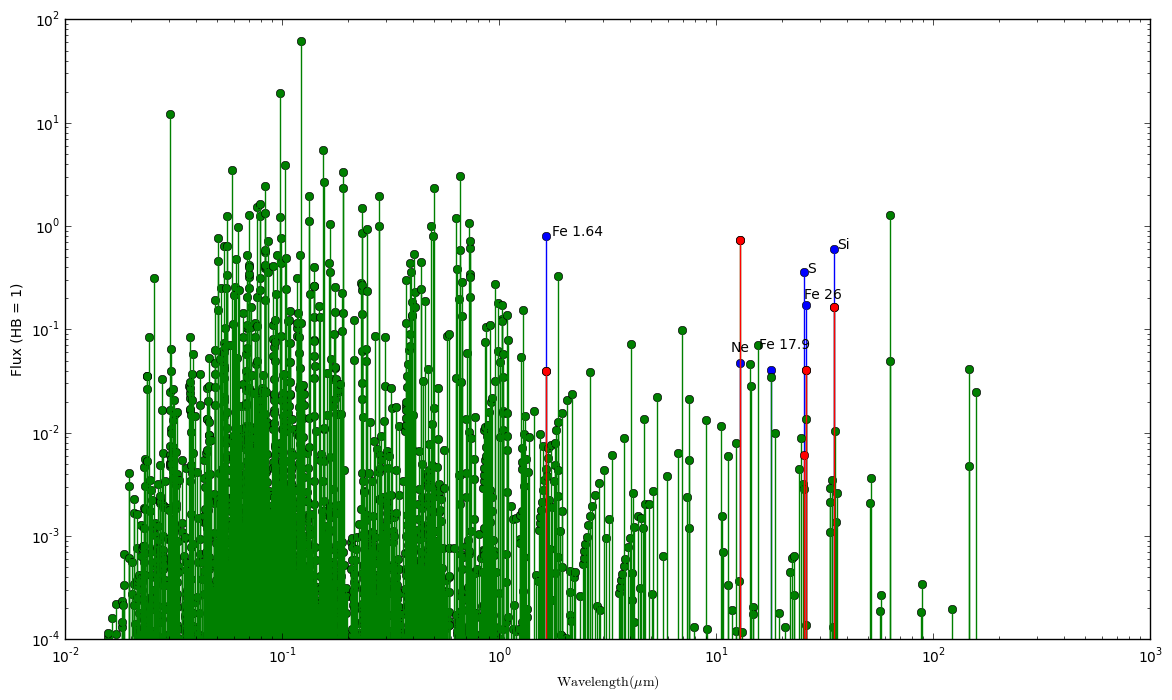

('Observed:', [0.60385347928674671, 0.17365045056880379, 0.36036056065829125, 0.04015199684448395, 0.046893224276805125, 0.80720965804686828])
('Simulated:', [0.16408, 0.040761, 0.0060586, 0.0, 0.74141, 0.03942])
('Differences: Si', 0.4397734792867467, ', Fe26', 0.1328894505688038, ', S', 0.35430196065829123, ', Fe179', 0.04015199684448395, ', Ne', -0.69451677572319492, ', Fe16', 0.76778965804686827)


In [41]:
plotspectra(bhigh[130], 0, 8.150551591068386e-13)

In [ ]:
# 'S5_Shocks/NewMid/ShockFiles/ShockSpectrum*.csv'